In [ ]:
import shap
from sklearn.metrics import r2_score
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)
import pandas as pd
import numpy as np
import optuna

# XGBoost & Evaluation
import xgboost as xgb
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import cross_val_score, RepeatedKFold

import matplotlib.pyplot as plt
%matplotlib inline


# Load Synthetic and Real Data

real_data = pd.read_csv("real.csv")
synthetic_data = pd.read_csv("synthetic.csv")

columns = [col for col in real_data.columns]

target_column = "Mu"

X_train = synthetic_data.drop(columns=[target_column])
y_train = synthetic_data[target_column]


X_test = real_data.drop(columns=[target_column])
y_test = real_data[target_column]


# Define the Optuna Objective

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=20),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.02, 0.03, 0.05, 0.1, 0.2]),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        "gamma": trial.suggest_categorical("gamma", [0.001, 0.05, 0.1, 0.2, 1]),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [0.1, 0.5, 1]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [0.1, 0.5, 1]),
        "objective": "reg:squarederror"
    }

    model = xgb.XGBRegressor(**params, random_state=42)

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                             cv=cv, scoring="neg_mean_squared_error")

    return -np.mean(scores)


# Run the Optuna Study

study = optuna.create_study(
    direction="minimize", study_name="XGB_SyntheticOnly")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n✅ Best Hyperparameters from CV on Synthetic Data:")
print(study.best_params)


# Retrain Final Model on All Synthetic Data
final_model = xgb.XGBRegressor(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the Final Model on Real Data
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Metrics: Train (Synthetic)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = (mean_squared_error(y_train, y_train_pred)) ** 0.5
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

# Metrics: Test (Real Data)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = (mean_squared_error(y_test, y_test_pred)) ** 0.5
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n📊 Model Evaluation Metrics:")
print("\n📌 Train Set (Synthetic Data Only):")
print(f"R² Score: {r2_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MAPE: {mape_train:.4f}")

print("\n📌 Test Set (All Real Data):")
print(f"R² Score: {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MAPE: {mape_test:.4f}")

[I 2025-12-05 19:34:02,709] A new study created in memory with name: XGB_SyntheticOnly


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:34:18,998] Trial 0 finished with value: 78.44969219069776 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 0 with value: 78.44969219069776.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:34:41,019] Trial 1 finished with value: 65.5721770016171 and parameters: {'n_estimators': 190, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:34:45,440] Trial 2 finished with value: 77.77544854133912 and parameters: {'n_estimators': 170, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:34:51,269] Trial 3 finished with value: 82.81535616488982 and parameters: {'n_estimators': 190, 'learning_rate': 0.02, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.2, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:34:52,543] Trial 4 finished with value: 556.4528535282269 and parameters: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:02,999] Trial 5 finished with value: 90.76591545639668 and parameters: {'n_estimators': 270, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.5, 'colsample_bytree': 0.9, 'gamma': 0.001, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:06,493] Trial 6 finished with value: 82.19970093482748 and parameters: {'n_estimators': 210, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.05, 'reg_alpha': 1, 'reg_lambda': 1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:09,090] Trial 7 finished with value: 115.7835795896943 and parameters: {'n_estimators': 70, 'learning_rate': 0.2, 'max_depth': 11, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:19,324] Trial 8 finished with value: 75.51812012285139 and parameters: {'n_estimators': 250, 'learning_rate': 0.02, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:20,678] Trial 9 finished with value: 98.3235924174922 and parameters: {'n_estimators': 110, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.05, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:32,105] Trial 10 finished with value: 69.57800982397617 and parameters: {'n_estimators': 130, 'learning_rate': 0.2, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:43,017] Trial 11 finished with value: 69.57800982397617 and parameters: {'n_estimators': 130, 'learning_rate': 0.2, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 1 with value: 65.5721770016171.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:35:54,785] Trial 12 finished with value: 63.925628227441365 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:03,850] Trial 13 finished with value: 65.69330950189546 and parameters: {'n_estimators': 210, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:14,686] Trial 14 finished with value: 96.20240339874863 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 11, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:21,757] Trial 15 finished with value: 75.41227585600862 and parameters: {'n_estimators': 90, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:39,312] Trial 16 finished with value: 78.55186377994983 and parameters: {'n_estimators': 170, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:50,398] Trial 17 finished with value: 100.3465260944656 and parameters: {'n_estimators': 210, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:36:59,262] Trial 18 finished with value: 79.59793743175433 and parameters: {'n_estimators': 290, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.2, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:37:03,569] Trial 19 finished with value: 99.59730433924308 and parameters: {'n_estimators': 130, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.05, 'reg_alpha': 1, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:37:30,281] Trial 20 finished with value: 93.17776198954803 and parameters: {'n_estimators': 230, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:37:41,035] Trial 21 finished with value: 65.69376036070199 and parameters: {'n_estimators': 190, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:37:52,378] Trial 22 finished with value: 94.74450696883329 and parameters: {'n_estimators': 210, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:00,525] Trial 23 finished with value: 64.08637710038299 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:07,679] Trial 24 finished with value: 64.08637710038299 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:15,047] Trial 25 finished with value: 80.7288607455575 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:19,026] Trial 26 finished with value: 107.88534596339056 and parameters: {'n_estimators': 110, 'learning_rate': 0.02, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:22,492] Trial 27 finished with value: 66.97635687858993 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:28,279] Trial 28 finished with value: 93.2035172620643 and parameters: {'n_estimators': 90, 'learning_rate': 0.03, 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.001, 'reg_alpha': 1, 'reg_lambda': 1}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:30,560] Trial 29 finished with value: 99.12812613460946 and parameters: {'n_estimators': 110, 'learning_rate': 0.2, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:35,097] Trial 30 finished with value: 101.1013877857977 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.05, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:46,437] Trial 31 finished with value: 65.5721770016171 and parameters: {'n_estimators': 190, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 63.925628227441365.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:54,262] Trial 32 finished with value: 61.69827445858472 and parameters: {'n_estimators': 170, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 32 with value: 61.69827445858472.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:38:59,415] Trial 33 finished with value: 61.6842282626865 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.001, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 33 with value: 61.6842282626865.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:02,754] Trial 34 finished with value: 92.4938620818972 and parameters: {'n_estimators': 170, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 33 with value: 61.6842282626865.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:07,404] Trial 35 finished with value: 61.46969038299358 and parameters: {'n_estimators': 170, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:09,436] Trial 36 finished with value: 97.65752011399744 and parameters: {'n_estimators': 170, 'learning_rate': 0.03, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.5, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:12,030] Trial 37 finished with value: 131.73618365328056 and parameters: {'n_estimators': 190, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:13,938] Trial 38 finished with value: 105.92624791612396 and parameters: {'n_estimators': 130, 'learning_rate': 0.02, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:20,547] Trial 39 finished with value: 65.63610523833376 and parameters: {'n_estimators': 230, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 1}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:24,297] Trial 40 finished with value: 63.47282980260238 and parameters: {'n_estimators': 170, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:28,341] Trial 41 finished with value: 63.47282980260238 and parameters: {'n_estimators': 170, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:34,413] Trial 42 finished with value: 63.58199140987396 and parameters: {'n_estimators': 190, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:37,045] Trial 43 finished with value: 63.81488880542462 and parameters: {'n_estimators': 170, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:39,794] Trial 44 finished with value: 74.55860517389114 and parameters: {'n_estimators': 170, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:47,741] Trial 45 finished with value: 63.01207642870062 and parameters: {'n_estimators': 190, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:53,934] Trial 46 finished with value: 77.3693914755316 and parameters: {'n_estimators': 230, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:39:58,178] Trial 47 finished with value: 73.22522767698158 and parameters: {'n_estimators': 190, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:40:02,446] Trial 48 finished with value: 63.58199140987396 and parameters: {'n_estimators': 190, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 35 with value: 61.46969038299358.


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [50, 300] and step=20, but the range is not divisible by `step`. It will be replaced with [50, 290].
  warnings.warn(


[I 2025-12-05 19:40:05,929] Trial 49 finished with value: 184.68593321815013 and parameters: {'n_estimators': 130, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 35 with value: 61.46969038299358.

✅ Best Hyperparameters from CV on Synthetic Data:
{'n_estimators': 170, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 0.5}

📊 Model Evaluation Metrics:

📌 Train Set (Synthetic Data Only):
R² Score: 0.9987
RMSE: 1.2614
MAE: 0.9694
MAPE: 0.0292

📌 Test Set (All Real Data):
R² Score: 0.9890
RMSE: 4.0622
MAE: 2.8946
MAPE: 0.0859


/tmp/ipython-input-3183705880.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


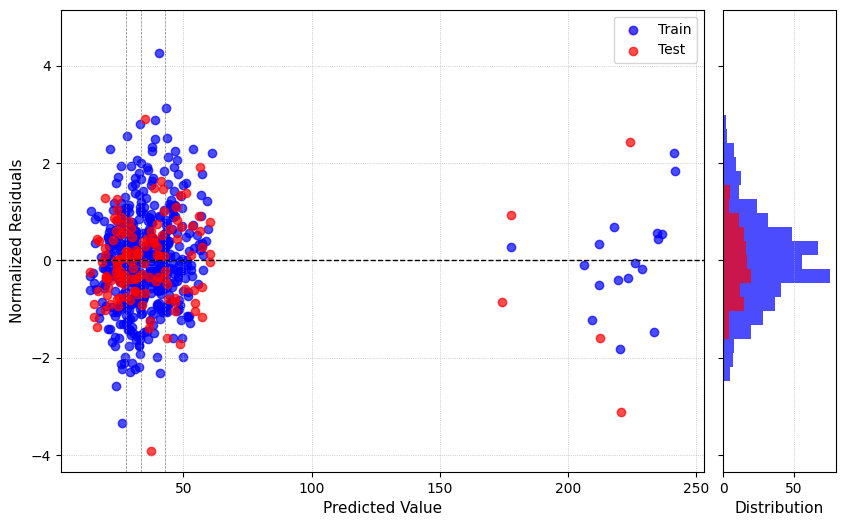

In [ ]:
# Compute residuals
resid_train = y_train - y_train_pred
resid_test = y_test - y_test_pred
resid_train_norm = (resid_train - np.mean(resid_train)) / np.std(resid_train)
resid_test_norm = (resid_test - np.mean(resid_test)) / np.std(resid_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test,  y_test_pred)

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 0.7], wspace=0.05)

ax_scatter = fig.add_subplot(gs[0, 0])
ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_scatter)

ax_scatter.scatter(y_train_pred, resid_train_norm,
                   color='blue', alpha=0.7, label='Train')
ax_scatter.scatter(y_test_pred, resid_test_norm,
                   color='red', alpha=0.7, label='Test')

ax_scatter.axhline(0, color='black', linestyle='--', linewidth=1)

for q in [0.25, 0.5, 0.75]:
    val = np.quantile(y_train_pred, q)
    ax_scatter.axvline(val, color='gray', linestyle='--', linewidth=0.5)

ax_scatter.set_xlabel("Predicted Value", fontsize=11,
                      fontweight='normal')  # or 'bold'
ax_scatter.set_ylabel("Normalized Residuals", fontsize=11, fontweight='normal')

ax_scatter.set_title("")
ax_scatter.legend(loc="upper right")
ax_scatter.grid(which='major', linestyle=':', linewidth=0.5)


ax_scatter.text(
    60, 3,
    " ",
    fontsize=13, fontweight='bold', color='black'
)

bins = np.histogram_bin_edges(np.concatenate(
    [resid_train_norm, resid_test_norm]), bins=30)
ax_hist.hist(resid_train_norm, bins=bins,
             orientation='horizontal', color='blue', alpha=0.7)
ax_hist.hist(resid_test_norm,  bins=bins,
             orientation='horizontal', color='red', alpha=0.7)

ax_hist.set_xlabel("Distribution", fontsize=11, fontweight='normal')

ax_hist.set_title("")
ax_hist.grid(axis='x', linestyle=':', linewidth=0.5)

plt.setp(ax_hist.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

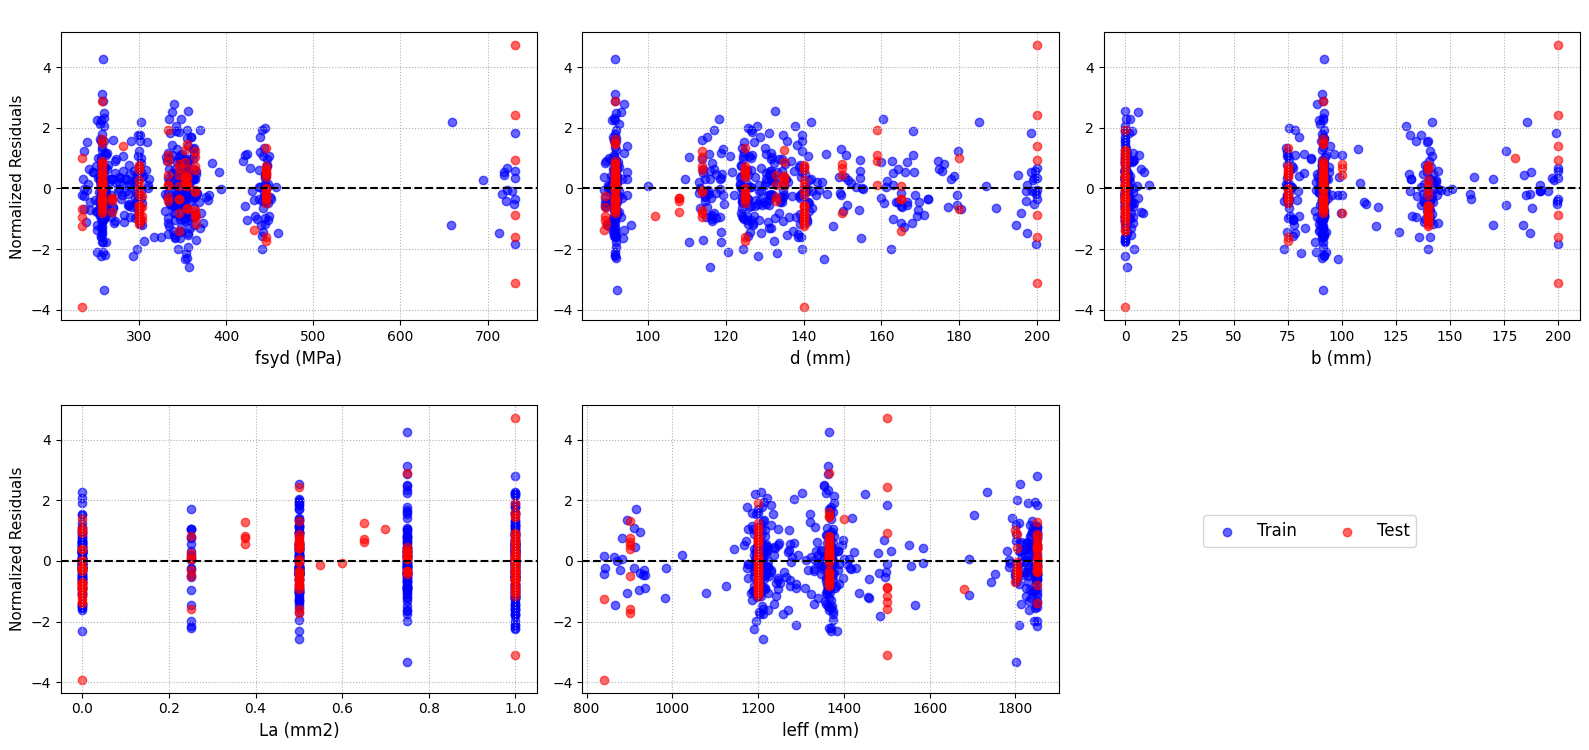

In [ ]:
features_to_plot = ['fsyd (MPa)', 'd (mm)', 'b (mm)', 'La (mm2)', 'leff (mm)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    ax.scatter(X_train[feature], resid_train_norm,
               color='blue', alpha=0.6, label='Train')
    ax.scatter(X_test[feature], resid_test_norm,
               color='red', alpha=0.6, label='Test')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel(feature, fontsize=12)

    if i % 3 == 0:
        ax.set_ylabel("Normalized Residuals", fontsize=11)
    else:
        ax.set_ylabel("")

    ax.set_title(" ")
    ax.grid(True, linestyle=':')

for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower left',
           bbox_to_anchor=(0.75, 0.25),
           ncol=2,
           fontsize=12,
           frameon=True)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

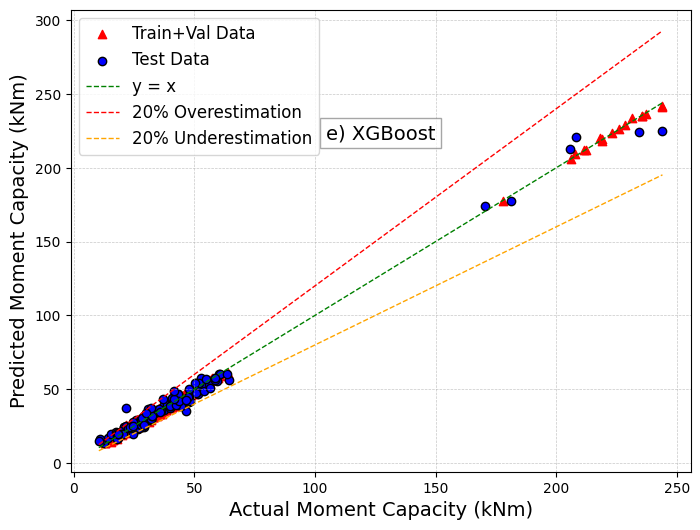

In [ ]:
# Scatter Plot: Actual vs. Predicted

plt.figure(figsize=(8, 6))


plt.scatter(
    y_train, y_train_pred,
    color='red', alpha=1, edgecolor='red', marker='^', label='Train+Val Data'
)


plt.scatter(
    y_test, y_test_pred,
    color='blue', alpha=1, edgecolor='black', marker='o', label='Test Data'
)

y_min = min(min(y_train), min(y_test))
y_max = max(max(y_train), max(y_test))
plt.plot([y_min, y_max], [y_min, y_max], color='green',
         linestyle='--', linewidth=1, label='y = x')

plt.plot([y_min, y_max], [y_min * 1.2, y_max * 1.2],
         'r--', linewidth=1, label='20% Overestimation')
plt.plot([y_min, y_max], [y_min * 0.8, y_max * 0.8], 'orange',
         linestyle='--', linewidth=1, label='20% Underestimation')

plt.xlabel("Actual Moment Capacity (kNm)", fontsize=14, color='black')
plt.ylabel("Predicted Moment Capacity (kNm)", fontsize=14, color='black')
plt.text(
    0.5 * (y_min + y_max),
    0.9 * y_max,
    "e) XGBoost",
    fontsize=14,
    ha='center',
    color='black',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.legend(fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


--- SHAP Analysis ---


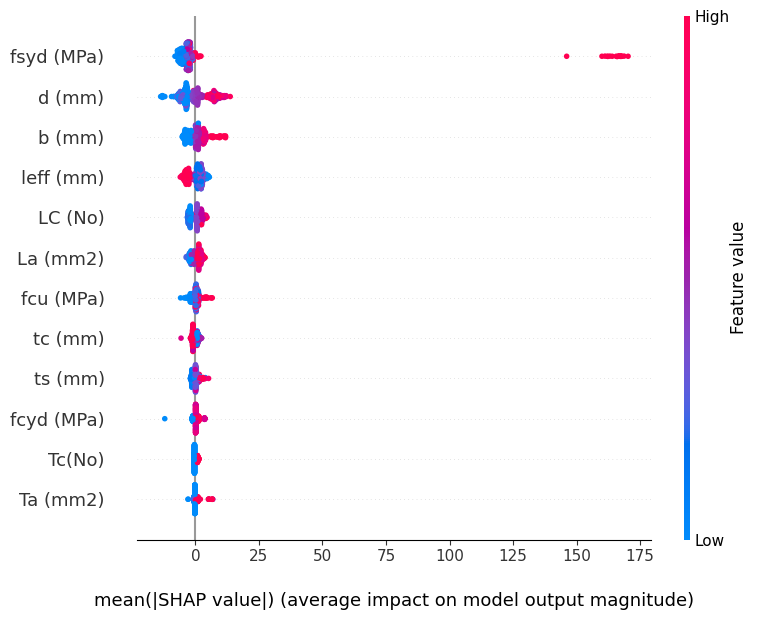

In [ ]:
# SHAP Analysis
print("\n--- SHAP Analysis ---")

plt.figure(figsize=(8, 6))
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.titlecolor': 'black',
    'axes.labelsize': 20,
    'axes.labelcolor': 'black'
})

explainer = shap.TreeExplainer(final_model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train,
                  feature_names=X_train.columns, show=False)

plt.xlabel(
    "mean(|SHAP value|) (average impact on model output magnitude)", labelpad=20)

plt.tight_layout()
plt.show()

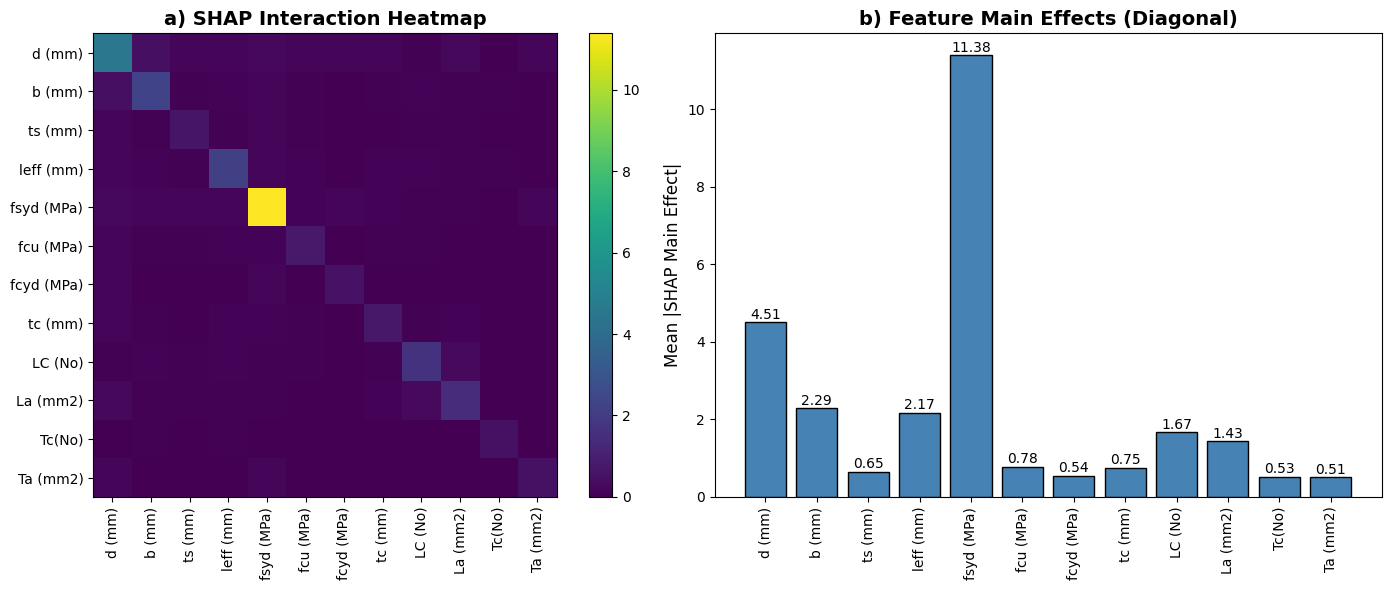

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_interacts = explainer.shap_interaction_values(X_train)
mean_interacts = np.abs(shap_interacts).mean(axis=0)

features = X_train.columns
main_effects = np.diag(mean_interacts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6),
                               gridspec_kw={'width_ratios': [1.1, 0.9]})

im = ax1.imshow(mean_interacts, cmap='viridis')
ax1.set_xticks(range(len(features)))
ax1.set_yticks(range(len(features)))
ax1.set_xticklabels(features, rotation=90, fontsize=10)
ax1.set_yticklabels(features, fontsize=10)
ax1.set_title("a) SHAP Interaction Heatmap", fontsize=14, fontweight='bold')
cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

bars = ax2.bar(features, main_effects, color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(features)))
ax2.set_xticklabels(features, rotation=90, fontsize=10)
ax2.set_ylabel("Mean |SHAP Main Effect|", fontsize=12)
ax2.set_title("b) Feature Main Effects (Diagonal)",
              fontsize=14, fontweight='bold')

top_k = 12
top_indices = np.argsort(main_effects)[-top_k:]
for i in top_indices:
    ax2.text(i, main_effects[i] + 0.01,
             f"{main_effects[i]:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()